In [1]:
import numpy as np
import pandas as pd
import re

from IPython.display import display
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize  
import nltk
from collections import Counter
import string

from konlpy.tag import Kkma
from konlpy.tag import Mecab
from konlpy.utils import pprint
from konlpy.tag import Twitter,Okt

import os

from tqdm import tqdm
import ast

from gensim.models import Word2Vec
import random

import timeit

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model



from imblearn.over_sampling import SMOTE

import random

In [2]:
twitter = Twitter()
kkma = Kkma()

C:\Users\Samsung\anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [3]:
data_ = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\sentiment analysis\supervised\스킨케어_plus.xlsx")
data_["Rate"] = [int(ra.replace("0","").replace("s","")) for ra in data_["rates"]]
start = timeit.default_timer()
pos_list = []
for word in tqdm(data_["Contents"]):
    pos_list.append(twitter.pos(word))

data_["POS"] = pos_list    

stop = timeit.default_timer()

print('Time: ', stop - start) 
data_.head()

100%|███████████████████████████████████████████████████████████████████████████| 36253/36253 [04:51<00:00, 124.36it/s]


Time:  291.6565284999999


,Unnamed: 0,ID,Date,Contents,rates,Rate,POS
0,0,bjr*******,2020/11/24,약간 끈적이는 감이 있지않나 싶을쯤 싸악 스며들어서 좋아요~ 홈쇼핑방송처럼 드라마틱...,s50,5,"[(약간, Noun), (끈, Noun), (적, Suffix), (이는, Verb..."
1,1,jan******@126.com,2020/11/17,박수홍씨 홈쇼핑하는거보고 믿고 구매해봤어요.용량부족하다는 품평이 많아서 받자마자 뜯...,s50,5,"[(박수홍, Noun), (씨, Suffix), (홈쇼핑, Noun), (하는거, ..."
2,2,yja****,2020/11/15,잘받았습니다..늘 사용하는 제품입니다..,s50,5,"[(잘, VerbPrefix), (받았습니다, Verb), (.., Punctuat..."
3,3,mod****@naver.com,2020/11/14,이것만 써요. 수홍씨 피부좋아진거 보고 작년부터 재구매중이에요,s50,5,"[(이, Determiner), (것, Noun), (만, Josa), (써요, V..."
4,4,sta*****,2020/11/11,딸이 좋아해서 계속시키네요,s50,5,"[(딸, Noun), (이, Josa), (좋아해서, Adjective), (계속,..."


# 1. Voca 만들기

In [4]:
def tokenize(doc):
    return ["/".join(t) for t in doc]

In [5]:
def term_frequency(doc):
    return [doc.count(word) for word in selected]

In [6]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    plt.subplot(2,1,1)
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.plot(hist["epoch"],hist["loss"],label="train_loss")
    plt.plot(hist["epoch"],hist["val_loss"],label="val_loss")
    
    plt.subplot(2,1,2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(hist["epoch"],hist["acc"],label="train_acc")
    plt.plot(hist["epoch"],hist["val_acc"],label="val_acc")
    
    plt.legend()
    plt.show()
    

In [7]:
data_["POS_join"] = [tokenize(pos) for pos in data_["POS"]]
data_set = [(row[0],row[1]) for row in data_[["POS_join","Rate"]].values]

set_1 = [i for i in data_set if i[1]==1]
set_2 = [i for i in data_set if i[1]==2]
set_3 = [i for i in data_set if i[1]==3]
set_4 = [i for i in data_set if i[1]==4]
set_5 = [i for i in data_set if i[1]==5]


## 1,2 은 negative / 4,5 positive / 3은애매하니까 제외

set_1_ne = [(n,0) for n,j in set_1]
set_2_ne = [(n,0) for n,j in set_2]
set_4_ne = [(n,1) for n,j in set_4]
set_5_ne = [(n,1) for n,j in set_5]

data_imbal = []
data_imbal.extend(random.sample(set_1_ne,500))
data_imbal.extend(random.sample(set_2_ne,500))
data_imbal.extend(random.sample(set_4_ne,500))
data_imbal.extend(random.sample(set_5_ne,500))

In [8]:
tokens_all = [t for d in data_imbal for t in d[0]]
tag_only = ['Noun',  'Verb', 'Josa', 'Adjective',
             'Adverb', 'Determiner', 'VerbPrefix', 
            'Modifier',  'Number', 
            'KoreanParticle', 'Conjunction',  'Eomi']

tokens_only = []
for i in tokens_all:
    try:
        word_,pos_ = i.split("/")
        if pos_ in tag_only:
            tokens_only.append(i)
    except:
        pass

In [9]:
text = nltk.Text(tokens_only,name="NMSC")
len(text.vocab().most_common())

6448

In [10]:
topn = 6631

text.vocab().most_common(topn)
selected = [f[0] for f in text.vocab().most_common(topn)]

In [11]:
topn = len(selected)
len(selected)

6448

# ANN

In [25]:
train, test = train_test_split(data_imbal, test_size=0.2)
train_x = [term_frequency(d) for d, _ in train]
test_x = [term_frequency(d) for d, _ in test]
train_y = [c for _, c in train]
test_y = [c for _, c in test]
x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')
y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [26]:
#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(6589,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss="binary_crossentropy",
    metrics=["acc"]
    )

history = model.fit(x_train, y_train, epochs=15,validation_split=0.1 ,batch_size=512)
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

Epoch 1/15
3/3 [==============================] - 0s 112ms/step - loss: 0.6815 - acc: 0.6118 - val_loss: 0.6667 - val_acc: 0.6438
Epoch 2/15
3/3 [==============================] - 0s 13ms/step - loss: 0.6166 - acc: 0.8611 - val_loss: 0.6268 - val_acc: 0.7625
Epoch 3/15
3/3 [==============================] - 0s 12ms/step - loss: 0.5390 - acc: 0.9229 - val_loss: 0.5904 - val_acc: 0.7875
Epoch 4/15
3/3 [==============================] - 0s 13ms/step - loss: 0.4596 - acc: 0.9243 - val_loss: 0.5486 - val_acc: 0.7812
Epoch 5/15
3/3 [==============================] - 0s 13ms/step - loss: 0.3890 - acc: 0.9347 - val_loss: 0.5323 - val_acc: 0.7812
Epoch 6/15
3/3 [==============================] - 0s 13ms/step - loss: 0.3292 - acc: 0.9507 - val_loss: 0.4976 - val_acc: 0.7937
Epoch 7/15
3/3 [==============================] - 0s 15ms/step - loss: 0.2809 - acc: 0.9542 - val_loss: 0.4909 - val_acc: 0.7812
Epoch 8/15
3/3 [==============================] - 0s 18ms/step - loss: 0.2407 - acc: 0.9639 - va

In [27]:
hist.tail()

,loss,acc,val_loss,val_acc,epoch
10,0.157170,0.971528,0.478490,0.78125,10
11,0.136746,0.974306,0.484692,0.80000,11
12,0.119993,0.977778,0.485352,0.80000,12
13,0.105642,0.981944,0.492920,0.78750,13
14,0.092934,0.983333,0.508237,0.78750,14


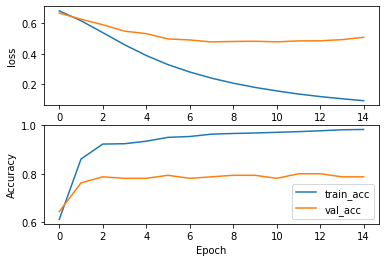

In [28]:
plot_history(history)

In [29]:
results = model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 921us/step - loss: 0.4175 - acc: 0.8200


In [96]:
review = "가성비도 좋고 생각보다 피부에 좋아요"
pos_rev = twitter.pos(review)
token = tokenize(pos_rev)
tf1 = term_frequency(token)
data = np.expand_dims(np.asarray(tf1).astype('float32'), axis=0)
float(model.predict(data))

0.9034187197685242

In [107]:
review = "마음먹고 한번 구입해 보았는데, 생각 보다 질도 않 좋고, 별로네요 최악"
pos_rev = twitter.pos(review)
token = tokenize(pos_rev)
tf1 = term_frequency(token)
data = np.expand_dims(np.asarray(tf1).astype('float32'), axis=0)
float(model.predict(data))

0.4508243501186371

In [106]:
review = "마음먹고 한번 구입해 보았는데, 생각 보다 질도 않 좋고, 별로네요 가성비도 최악"
pos_rev = twitter.pos(review)
token = tokenize(pos_rev)
tf1 = term_frequency(token)
data = np.expand_dims(np.asarray(tf1).astype('float32'), axis=0)
float(model.predict(data))

0.5464159250259399

In [33]:
review = "마음먹고 한번 구입해 보았는데, 생각 보다 질도 않 좋고, 별로네요 가성비"
pos_rev = twitter.pos(review)
token = tokenize(pos_rev)
tf1 = term_frequency(token)
data = np.expand_dims(np.asarray(tf1).astype('float32'), axis=0)
float(model.predict(data))

0.7824869751930237

In [34]:
review = "마음먹고 한번 구입해 보았는데, 생각 보다 질도 않 좋고, 별로네요"
pos_rev = twitter.pos(review)
token = tokenize(pos_rev)
tf1 = term_frequency(token)
data = np.expand_dims(np.asarray(tf1).astype('float32'), axis=0)
float(model.predict(data))

0.7336323261260986

In [35]:
review = "그닥.. 별로인듯해요"
pos_rev = twitter.pos(review)
token = tokenize(pos_rev)
tf1 = term_frequency(token)
data = np.expand_dims(np.asarray(tf1).astype('float32'), axis=0)
float(model.predict(data))

0.3510132431983948

## Extraction

In [136]:
voca_ad = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\sentiment analysis\voca\try_1\total_ad.xlsx")
voca_adj = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\sentiment analysis\voca\try_1\total_adj.xlsx")
voca_n = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\sentiment analysis\voca\try_1\total_n.xlsx")
voca_v = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\sentiment analysis\voca\try_1\total_v.xlsx")

voca_all = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\data\result\result_long\most_long\most_tf_idf\TFIDF_스킨 케어_Adj.xlsx")
voca_all2 = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\data\result\result_long\most_long\most_tf_idf\TFIDF_스킨 케어_Noun.xlsx")
voca_all3 = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\data\result\result_long\most_long\most_tf_idf\TFIDF_스킨 케어_Adverb.xlsx")
voca_all4 = pd.read_excel(r"C:\Users\Samsung\Desktop\Project\이희정 교수님\project\data\result\result_long\most_long\most_tf_idf\TFIDF_스킨 케어_Verb.xlsx")

In [137]:
voca_nadj = pd.concat([voca_n,voca_adj]).reset_index()["word"]
Voca_ = pd.concat([voca_nadj,voca_all4["word"],voca_all3["word"],voca_all2["word"],voca_all["word"]]).reset_index()["word"]
Voca_ = set(Voca_)

In [138]:
def tester(review):
    pos_rev = kkma.pos(review)
    token = tokenize(pos_rev)
    token_ = [w.split("/")[0] for w in token]
    tf1 = term_frequency(token_)
    data = np.expand_dims(np.asarray(tf1).astype('float32'), axis=0)
    score = float(model.predict(data))
    ta_ = [word for word in Voca_]
    extrac_ = [W for W in token_ if W in ta_]
    return score,extrac_

In [139]:
tester("가성비도 좋고 생각보다 피부에 좋아요")

(0.5730999708175659, ['가', '아', '좋', '고', '생각', '보다', '피부', '에', '좋'])

In [140]:
tester("마음먹고 한번 구입해 보았는데, 생각 보다 질도 않 좋고, 별로네요 최악")

(0.5730999708175659,
 ['고', '한번', '구입', '하', '어', '보', '생각', '보다', '않', '좋', '고', '별로', '요'])

# RNN 모델로 

In [110]:
def split_(List):
    List2 = []
    for li in List:
        List2.append(li.split("/")[0])
    return List2

In [111]:
x_  = [split_(d) for d,_ in data_imbal]
y_ = [c for _,c in data_imbal]

In [112]:
# padding
max_len = max([len(x) for x in x_])
padding_lambda = lambda x: x + [""]*(max_len-len(x))
x_padding =  list(map(padding_lambda,x_))

In [113]:
voca_li = list(Counter([i.split("/")[0] for i in tokens_only]).keys())
data_const = tf.constant(x_padding)

In [114]:
len(voca_li)

6456

In [115]:
encoder = preprocessing.StringLookup(vocabulary=voca_li)
x_vector = encoder(data_const)

In [116]:
x_vector

<tf.Tensor: shape=(2000, 415), dtype=int64, numpy=
array([[   2,    3,    4, ...,    0,    0,    0],
       [  24,   25,   26, ...,    0,    0,    0],
       [  40,   41,    1, ...,    0,    0,    0],
       ...,
       [ 263,   51,   40, ...,    0,    0,    0],
       [1643, 6449, 6450, ...,    0,    0,    0],
       [6457,  211,   73, ...,    0,    0,    0]], dtype=int64)>

In [117]:
# strion 안으로 변환후에 다시 써보자 
x_string  = [" , ".join(i) for i in x_]
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization()
encoder.adapt(x_string)
x_vector_2 = encoder(x_string)

In [118]:
x_string[0]

'한번 , 도 , 화장품 , 발라 , 서 , 얼굴 , 이 , 뒤집 , 힌 , 적 , 없는데 , , , 유일하게 , 한번 , 바르고 , 얼굴 , 완전 , 뒤집힌 , 화장품 , . , 좁쌀 , 만 , 한 , 것 , 이 , 온 , 얼굴 , 에 , 뒤집어짐 , . , 절대 , 비추 , !!'

In [119]:
encoder.get_vocabulary()[0:10]

['', '[UNK]', '이', '에', '가', '도', '사용', '은', '잘', '는']

In [120]:
x_vector_2

<tf.Tensor: shape=(2000, 387), dtype=int64, numpy=
array([[  72,    5,  120, ...,    0,    0,    0],
       [  43,  651,  240, ...,    0,    0,    0],
       [   8,  196,   49, ...,    0,    0,    0],
       ...,
       [ 128,    4,    8, ...,    0,    0,    0],
       [2181, 3728, 6107, ...,    0,    0,    0],
       [5394,   31,    6, ...,    0,    0,    0]], dtype=int64)>

### Bidirectional RNN

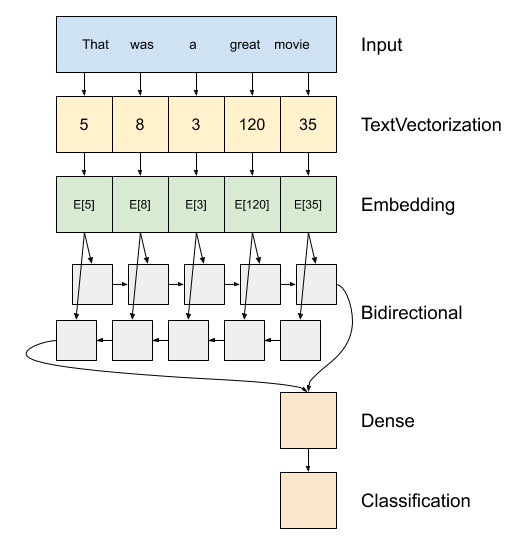

In [121]:
input_len =  len(encoder.get_vocabulary())
input_len

6534

In [122]:
def build_model():
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy'])

    return model

In [123]:
def build_model2():
    model = tf.keras.Sequential(encoder)
    #model.add(encoder)
    model.add(layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True))
    model.add(layers.SimpleRNN(64, return_sequences=False))
    model.add(layers.Dense(8,activation="softmax"))
    model.add(layers.Dense(1))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy'])

    return model

In [124]:
def build_model3():
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy'])

    return model

In [125]:
model_1 = build_model()

In [126]:
data_vector = []
for i in range(len(x_string)):
    data_vector.append((x_string[i],y_[i]))

In [127]:
train, test = train_test_split(data_vector, test_size=0.2)


train_x = [d for d, _ in train]
test_x = [d for d, _ in test]
train_y = [c for _, c in train]
test_y = [c for _, c in test]

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [128]:
history = model_1.fit(train_x, train_y,epochs=10)
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

Epoch 1/10
50/50 [==============================] - 3s 54ms/step - loss: 0.6928 - accuracy: 0.5019
Epoch 2/10
50/50 [==============================] - 3s 53ms/step - loss: 0.6907 - accuracy: 0.5019
Epoch 3/10
50/50 [==============================] - 3s 54ms/step - loss: 0.6861 - accuracy: 0.5019
Epoch 4/10
50/50 [==============================] - 3s 60ms/step - loss: 0.6619 - accuracy: 0.5019
Epoch 5/10
50/50 [==============================] - 3s 56ms/step - loss: 0.5196 - accuracy: 0.6044
Epoch 6/10
50/50 [==============================] - 3s 55ms/step - loss: 0.3916 - accuracy: 0.7869
Epoch 7/10
50/50 [==============================] - 3s 52ms/step - loss: 0.3369 - accuracy: 0.8450
Epoch 8/10
50/50 [==============================] - 3s 54ms/step - loss: 0.2825 - accuracy: 0.8819
Epoch 9/10
50/50 [==============================] - 3s 61ms/step - loss: 0.2524 - accuracy: 0.9050
Epoch 10/10
50/50 [==============================] - 3s 51ms/step - loss: 0.2286 - accuracy: 0.9294 0s - loss

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

In [129]:
test_loss, test_acc = model_1.evaluate(test_x,test_y)

13/13 [==============================] - 0s 12ms/step - loss: 0.7166 - accuracy: 0.7775


In [133]:
i = 0 
print(test_x[i])
model_1.predict(np.array([test_x[i]]))

 , 방송 , 기다리고 , 있었어요 , ~


array([[1.1976914]], dtype=float32)

In [135]:
i = 2 
print(test_x[i])
model_1.predict(np.array([test_x[i]]))

  , 색조화 , 장할 , 때 , 밀릴까봐 , 걱정 , 했는데 , 밀리지도 , 않고 , 좋아요 , ㅡ


array([[4.372138]], dtype=float32)

In [303]:
sample_text = twitter.pos('생각보다 피부에도 좋지않고,  최악인 것 같아요. 비추천해요')
s_t = [w[0] for w in sample_text]
test_string = " , ".join(s_t)
predictions = model_1.predict(np.array([test_string]))
predictions

array([[-1.3249133]], dtype=float32)

In [295]:
sample_text = twitter.pos('정말 좋은 것 같아요')
s_t = [w[0] for w in sample_text]
test_string = " , ".join(s_t)
predictions = model_1.predict(np.array([test_string]))
predictions

array([[0.5818152]], dtype=float32)

In [304]:
sample_text = twitter.pos('정말 추천해요 피부에도 가성비도 좋은 것 같아요')
s_t = [w[0] for w in sample_text]
test_string = " , ".join(s_t)
predictions = model_1.predict(np.array([test_string]))
print(predictions)

[[0.78925055]]


In [246]:
model = build_model3()

In [247]:
data_vector = []
for i in range(len(x_string)):
    data_vector.append((x_string[i],y_[i]))

In [248]:
train, test = train_test_split(data_vector, test_size=0.2)


train_x = [d for d, _ in train]
test_x = [d for d, _ in test]
train_y = [c for _, c in train]
test_y = [c for _, c in test]

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [249]:
history = model.fit(train_x, train_y,epochs=10)
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

Epoch 1/10
50/50 [==============================] - 1s 21ms/step - loss: 0.6895 - accuracy: 0.4963
Epoch 2/10
50/50 [==============================] - 1s 19ms/step - loss: 0.6625 - accuracy: 0.4963
Epoch 3/10
50/50 [==============================] - 1s 19ms/step - loss: 0.6261 - accuracy: 0.4975
Epoch 4/10
50/50 [==============================] - 1s 20ms/step - loss: 0.5749 - accuracy: 0.5456
Epoch 5/10
50/50 [==============================] - 1s 20ms/step - loss: 0.5246 - accuracy: 0.6244
Epoch 6/10
50/50 [==============================] - 1s 20ms/step - loss: 0.4598 - accuracy: 0.6956
Epoch 7/10
50/50 [==============================] - 1s 20ms/step - loss: 0.4119 - accuracy: 0.7462
Epoch 8/10
50/50 [==============================] - 1s 21ms/step - loss: 0.3546 - accuracy: 0.8056
Epoch 9/10
50/50 [==============================] - 1s 20ms/step - loss: 0.3010 - accuracy: 0.8656
Epoch 10/10
50/50 [==============================] - 1s 20ms/step - loss: 0.2630 - accuracy: 0.9062


history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

In [250]:
test_loss, test_acc = model.evaluate(test_x,test_y)

13/13 [==============================] - 0s 7ms/step - loss: 0.5726 - accuracy: 0.7350


In [251]:
sample_text = ('생각보다 피부에도 좋지않고,  최악인 것 같아요')
predictions = model.predict(np.array([sample_text]))
predictions

array([[1.2017783]], dtype=float32)

In [252]:
sample_text = ('정말 좋은 것 같아요')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.71874285]], dtype=float32)

In [ ]:
x_string

## text 길이 문제

(array([161., 464., 288., 213., 143., 143., 106., 103.,  51.,  34.,  48.,
         33.,  26.,  28.,  20.,  16.,  11.,   8.,   2.,   6.,  15.,  13.,
         19.,   3.,   4.,   3.,   3.,   1.,   5.,   4.,   0.,   0.,   0.,
          2.,   1.,   0.,   0.,   8.,   1.,   2.,   0.,   0.,   0.,   0.,
          0.,   3.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([  1.  ,   5.14,   9.28,  13.42,  17.56,  21.7 ,  25.84,  29.98,
         34.12,  38.26,  42.4 ,  46.54,  50.68,  54.82,  58.96,  63.1 ,
         67.24,  71.38,  75.52,  79.66,  83.8 ,  87.94,  92.08,  96.22,
        100.36, 104.5 , 108.64, 112.78, 116.92, 121.06, 125.2 , 129.34,
        133.48, 137.62, 141.76

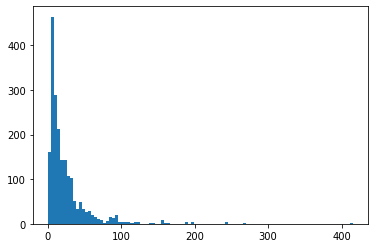

In [310]:
x_len = [len(x) for x in x_]
plt.hist(x_len,bins=100)